# Лекция 5. Работа с файлами в операционной системе Linux средствами ассемблера

1. Понятие файла.
2. Открытие файла, чтение из файла. Примеры программ: аналог команды cat, подсчет объема файла, подсчет заданных символов в файле.
3. Получение информации о файле, права доступа к файлам.
4. Позиционирование в файле, запись в файл, копирование.

## 1. Понятие файла

**Файл** — это самая простая и базовая абстракция в Linux. Linux придерживается философии «все есть файл». 

Следовательно, многочисленные взаимодействия представляют собой считывание из файлов и запись в них, даже если объект, с которым вы имеете дело, совсем не похож на «традиционный» файл.

Вообще, **чтобы получить доступ к файлу, его сначала нужно открыть. Файлы можно открывать для чтения, записи или того и другого сразу.** 

На открытый файл указывает **уникальный дескриптор, отображающий метаданные, ассоциированные
с открытым файлом**. 

В ядре Linux такой дескриптор файла задается некоторым целым числом (в системе типов C он соответствует целому числу 
int). Эта сущность, называемая **файловым дескриптором**, сокращенно обозначается **fd**. Дескрипторы файлов совместно используются в системе и пользовательском пространстве. Пользовательские программы применяют их непосредственно для
доступа к файлам. Значительная часть системного программирования в Linux сводится к открытию файлов, манипуляциям с ними, закрытию файлов и использованию файловых дескрипторов иными способами. 

Файловые дескрипторы начинаются со значения О и могут дойти до значения, на единицу меньше максимального. По умолчанию максимальное значение равно 1024, но при необходимости его можно повысить до 1 048 576. Файловые дескрипторы не могут иметь отрицательных значений, поэтому значение -1 часто применяется для индикации ошибки, полученной от функции. При отсутствии ошибки функция вернула бы валидный (допустимый) дескриптор файла. 

Каждый процесс традиционно имеет не менее трех открытых файловых дескрипторов: 0, 1 и 2, если, конечно, процесс явно не закрывает один из них. 

**Файловый дескриптор 0 соответствует стандартному вводу (stdin), дескриптор 1 — стандартному выводу (stdout), дескриптор 2 — стандартной ошибке (stderr)**. 

Как правило, stdin подключен к терминальному устройству ввода (обычно это пользовательская клавиатура), а stdout
и stderr — к дисплею терминала. 

Пользователи могут переназначать эти стандартные файловые дескрипторы и даже направлять по конвейеру вывод одной программы на ввод другой. Именно так оболочка реализует переназначения и конвейеры.

Дескрипторы могут ссылаться не только на обычные файлы, но и на файлы устройств и конвейеры, каталоги, сокеты. Это соответствует
парадигме «все есть файл». Практически любая информация, которую можно читать или записывать, доступна по файловому дескриптору.


### **Обычные файлы**

Сущности, которые большинству из нас известны под названием «файлы», в Linux именуются обычными файлами. Обычный файл содержит байты данных, организованные в виде линейного массива, который называется потоком байтов. В Linux
для файла не задается никаких других видов упорядочения или форматирования.
Байты могут иметь любые значения и быть организованы внутри файла любыми способами. На системном уровне Linux не регламентирует для файлов никакой структуры, кроме организации в виде потока байтов. 

Любые байты внутри файла могут использоваться для считывания или записи. Эти операции всегда начинаются с указанного байта, который можно назвать местоположением в файле. Это местоположение называется **файловой позицией
или смещением файла**. 

Файловая позиция — это важнейший элемент метаданных, который ядро ассоциирует с каждым открытием файла. 

**Когда файл открывается впервые, его файловая позиция равна нулю**. Обычно по мере того, как байты из
файла считываются либо в него записывается информация (байт за байтом), значение файловой позиции увеличивается. **Файловую позицию можно также вручную устанавливать в определенное значение**, причем оно может находиться даже за пределами (за последним байтом) конкретного файла. 

Когда файловая позиция находится за пределами файла, промежуточные байты будут заполняться нулями. Вполне возможно воспользоваться этим способом и задать файловую позицию дальше конца файла, однако вы никак не сможете установить эту позицию перед началом файла. Файловая позиция начинается с нуля; она не может иметь отрицательное значение. 

При записи в байт в середине файла значение, которое ранее находилось по этому смещению, заменяется новым, поэтому вы не сможете расширить файл, записывая информацию в его середину.

Как правило, запись в файл происходит в его конце. Максимальное значение
файловой позиции ограничено только размером типа C, используемого для хранения файла. В современных системах Linux максимальное значение этого параметра равно 64 бит.

Размер файла измеряется в байтах и называется его длиной. Можно сказать, что длина — это просто количество байтов в линейном массиве, составляющем файл.

Длину файла можно изменить с помощью операции, которая называется усечением. Файл можно укоротить, уменьшив его размер по сравнению с исходным. В результате будут удалены байты, расположенные в конце файла.

Отдельно взятый файл можно одновременно открыть несколько раз как в ином, так и в том же самом процессе. Каждому открытому экземпляру файла присваивается уникальный дескриптор. С другой стороны, процессы могут совместно использовать свои файловые дескрипторы, один дескриптор может применяться в нескольких процессах. Ядро не накладывает никаких ограничений на параллельный
доступ к файлу. Множественные процессы вполне могут одновременно считывать информацию из файла и записывать туда новые данные. Результаты такой параллельной работы зависят от упорядочения отдельных операций и, в принципе, непредсказуемы. 

Программы пользовательского пространства обычно должны
взаимно координироваться, чтобы обеспечить правильную синхронизацию параллельных обращений к файлам.

Хотя доступ к файлам обычно осуществляется по их именам, непосредственная связь файла с его названием отсутствует. В действительности ссылка на файл выполняется по **индексному дескриптору**. Этому дескриптору присваивается целочисленное значение, уникальное для файловой системы (но не обязательно уникальное во всей системе в целом). Данное значение называется номером индексного дескриптора. В индексном дескрипторе сохраняются метаданные, ассоциированные с файлом, например отметка о времени его последнего изменения, владелец файла, тип, длина и местоположение данных файла, но имя файла там не сохраняется!
Индексный дескриптор одновременно является и физическим объектом, расположенным на диске в UNIX-подобной файловой системе, и концептуальной сущностью, представленной как структура данных в ядре Linux.

### **Каталоги и ссылки**

Обращение к файлам по их индексным дескрипторам — довольно трудоемкий процесс (а также потенциальная брешь в системе безопасности), поэтому из пользовательского пространства файлы обычно вызываются по имени, а не по индексному дескриптору. Для предоставления имен, по которым можно обращаться к файлам, используются каталоги. 

**Каталог представляет собой отображение понятных человеку имен в номера индексных дескрипторов. Пара, состоящая из имени и индексного дескриптора, называется ссылкой**.

Физическая форма этого отображения, присутствующая на диске, например простая таблица или хеш, реализуется и управляется кодом ядра, поддерживающим конкретную файловую систему. 

В принципе, каталог ничем не отличается от обычного файла, за исключением того, что в нем
содержатся лишь отображения имен в индексные дескрипторы. Ядро непосредственно пользуется этими отображениями для разрешения имен в индексные дескрипторы.

Когда из пользовательского пространства приходит запрос на открытие файла с указанным именем, ядро открывает каталог, в котором содержится файл с таким названием, и ищет данное имя. По имени файла ядро получает номер его индексного дескриптора. По этому номеру находится сам индексный дескриптор.

Индексный дескриптор содержит метаданные, ассоциированные с файлом, в частности информацию о том, в каком именно фрагменте диска записаны данные этого файла.

Сначала на диске присутствует лишь один **корневой каталог**. К нему обычно ведет путь /. Однако, как известно, в любой системе, как правило, множество каталогов. 

Каталоги также ассоциированы со своими индексными дескрипторами, поэтому ссылки внутри каталогов могут указывать на индексные дескрипторы, находящиеся в других каталогах. Это означает, что одни каталоги можно вкладывать в другие, образуя иерархические структуры, что, в свою очередь, позволяет использовать
полные пути к элементам.

Когда мы запрашиваем у ядра открытие подобного пути к файлу, оно обходит все записи каталогов, указанные в пути к элементу. Так удается найти индексный дескриптор следующей записи. 

Кроме того, в ядре Linux используется кэш, называемый кэшем каталогов. В кэше каталогов сохраняются результаты разрешения каталогов, впоследствии обеспечивающие более быстрый поиск.

Если имя пути начинается с корневого каталога, говорят, что путь полностью
уточнен. Его называют **абсолютным путем к элементу**. Некоторые имена путей уточнены не полностью, а указываются относительно какого-то другого каталога
(например, ./MyLibrary). Такие пути называются **относительными**. 

Если ядру предоставляется относительный путь, то оно начинает разрешение пути с текущего рабочего каталога.

Хотя каталоги и воспринимаются как обычные файлы, ядро не позволяет их открывать и производить с ними те же манипуляции, что и с обычными файлами. **Для работы с каталогами используется специальный набор системных вызовов.**

Эти системные вызовы предназначаются для добавления и удаления ссылок — в принципе, на этом перечень разумных операций с каталогами заканчивается. Если бы можно было манипулировать каталогами прямо из пользовательского пространства, без посредничества ядра, то единственной простой ошибки хватило бы для повреждения всей файловой системы.

### **Жесткие ссылки**

С учетом всего вышесказанного ничто вроде бы не препятствует разрешению множества имен в один и тот же индексный дескриптор. Действительно, это допускается. **Когда множественные ссылки отображают различные имена на один и тот же индексный дескриптор, эти ссылки называются жесткими.**

Благодаря жестким ссылкам в файловых системах обеспечивается создание сложных структур, где множественные имена путей могут указывать на одни и те же данные. 

Эти жесткие ссылки могут находиться в одном каталоге, а также в двух и более различных каталогах. В любом случае ядро просто разрешает имя пути в верный индексный дескриптор. 

При удалении файла он отсоединяется от структуры каталогов. Для этого нужно просто удалить из каталога пару, в которой содержится имя файла и его индексный дескриптор. Однако, поскольку в Linux поддерживаются жесткие ссылки, файловая система не может просто уничтожать индексный дескриптор и ассоциированные с ним данные при каждой операции удаления. Что, если на этот файл были проставлены и другие жесткие ссылки из файловой системы? Чтобы гарантировать, что файл не будет уничтожен, пока не исчезнут все указывающие на него жесткие ссылки, в каждом индексном дескрипторе содержится счетчик ссылок, отслеживающий количество ссылок в файловой системе, указывающих на этот дескриптор. Когда путь к элементу отсоединяется от файловой системы, значение этого счетчика уменьшается на 1. Лишь если значение счетчика ссылок достигает нуля, и индексный дескриптор, и ассоциированные с ним данные окончательно удаляются из файловой системы.


### **Символьные ссылки**

Жесткие ссылки не могут связывать файловые системы, поскольку номер индексного дескриптора не имеет смысла вне его собственной файловой системы. Чтобы ссылки могли соединять информацию из различных файловых систем, становясь
при этом и более простыми, и менее прозрачными, в системах UNIX применяются так называемые символьные ссылки.

**Символьные ссылки похожи на обычные файлы. Такая ссылка имеет свой индексный дескриптор и ассоциированный с ним фрагмент данных, содержащий полное имя пути к связанному файлу.**

Таким образом, символьные ссылки могут указывать куда угодно, в том числе на файлы и каталоги, расположенные в иных файловых системах, и даже на несуществующие файлы и каталоги. Символьная ссылка, указывающая на несуществующий файл, называется сломанной.

C использованием символьных ссылок связано больше издержек, чем при работе с жесткими ссылками, так как символьная ссылка, в сущности, требует разрешения двух файлов: самой символьной ссылки и связанного с ней файла. При использовании жестких ссылок такие дополнительные затраты отсутствуют — нет разницы между обращениями к файлам, обладающим одной связью в файловой системе либо несколькими связями. 

Издержки при работе с символьными ссылками минимальны, но тем не менее они воспринимаются отрицательно.
Кроме того, символьные ссылки менее прозрачны, чем жесткие. 

Для манипуляций с символьными ссылками требуются специальные системные вызовы. Эта непрозрачность зачастую воспринимается как положительный момент, так как в символьной ссылке ее структура выражается открытым текстом. Символьные ссылки
используются именно как инструменты быстрого доступа (ярлыки), а не как внутрисистемные ссылки.

### **Специальные файлы**

**Специальные файлы** — это объекты ядра, представленные в виде файлов. С годами в системах UNIX накопилось множество типов поддерживаемых специальных файлов. В Linux поддерживается четыре типа таких файлов: **файлы блочных устройств, файлы символьных устройств, именованные каналы  и доменные сокеты UNIX**. 

Специальные файлы обеспечивают возможности встраивания определенных абстракций в файловую систему и, таким образом, поддерживают парадигму «все есть файл». Для создания специального файла в Linux предоставляется специальный системный вызов.

Доступ к устройствам в системах UNIX осуществляется через файлы устройств, которые выглядят и действуют как обычные файлы, расположенные в файловой системе. Файлы устройств можно открывать, считывать из них информацию и записывать ее в них. Из пользовательского пространства можно получать доступ к файлам устройств и манипулировать устройствами в системе (как физическими, так и виртуальными). 

Как правило, **все устройства в UNIX подразделяются на две группы — символьные устройства и блочные устройства**. 

Каждому типу устройства соответствует свой специальный файл устройства.

**Доступ к символьному устройству осуществляется как к линейной последовательности байтов.** Драйвер устройства ставит байты в очередь, один за другим, а программа из пользовательского пространства считывает байты в порядке, в котором они были помещены в очередь. Типичным примером символьного устройства является клавиатура. Если пользователь наберет на клавиатуре последовательность
**peg**, то приложению потребуется считать из файла-устройства клавиатуры сначала p, потом e и, наконец, g — именно в таком порядке. Когда больше не остается символов, которые необходимо прочитать, устройство возвращает «конец файла» (EOF). Если какой-то символ будет пропущен или символы будут прочтены в неправильном порядке, то операция получится фактически бессмысленной. 

Доступ к символьным устройствам происходит через **файлы символьных устройств**.


Напротив, доступ к **блочному устройству** происходит как к массиву байтов. Драйвер устройства отображает массив байтов на устройство с возможностью позиционирования, и пользовательское пространство может в произвольном порядке обращаться к любым валидным байтам массива, то есть можно сначала прочитать байт 12, потом байт 7, потом опять байт 12. **Блочные устройства — это обычно устройства для хранения информации. Жесткие диски, дисководы гибких дисков, CD-ROM, флэш-накопители — все это примеры блочных устройств. Доступ к ним осуществляется через файлы блочных устройств.**


**Именованные каналы** (часто обозначаемые аббревиатурой FIFO — «первым пришел, первым обслужен») — это механизм межпроцессного взаимодействия (IPC), предоставляющего канал связи для дескриптора файла. Доступ к именованному каналу выполняется через специальный файл. Обычные конвейеры применяются именно для того, чтобы «перекачивать» вывод одной программы во ввод другой; они
создаются в памяти посредством системного вызова и не существуют в какой-либо
файловой системе. 

Именованные каналы действуют как и обычные, но обращение к ним происходит через файл, называемый специальным файлом FIFO. Несвязанные процессы могут обращаться к этому файлу и обмениваться информацией.

Последний тип специальных файлов — это **сокеты**. Сокеты обеспечивают усовершенствованную разновидность межпроцессного взаимодействия между двумя несвязанными процессами — не только на одной машине, но и даже на двух разных.
На самом деле сокеты являются основополагающей концепцией всего программирования для сетей и Интернета. Существует множество разновидностей сокетов, в том числе **доменные сокеты UNIX**. Последние используются для взаимодействия на локальной машине. В то время как сокеты, обменивающиеся информацией по Интернету, могут использовать пару из хост-имени и порта для идентификации
«цели» взаимодействия, доменные сокеты используют для этого специальный файл, расположенный в файловой системе. Часто его называют просто **сокет-файлом**.

### **Файловые системы и пространства имен**

Linux, как и все системы UNIX, предоставляет глобальное и единое пространство имен для файлов и каталогов. В некоторых операционных системах отдельные физические и логические диски разделяются на самостоятельные пространства
имен. Например, для доступа к файлу на дискете может использоваться путь A:\plank.jpg, а пути ко всем файлам на жестком диске будут начинаться с C:\. 

В UNIX тот же файл с дискеты может быть доступен через /media/floppy/plank.jpg или даже через /home/captain/stuff/plank.jpg, в одном ряду с файлами с других носителей.

В этом и выражается единство пространства имен в UNIX. **Файловая система** — это набор файлов и каталогов формальной и валидной
иерархии. Файловые системы можно по отдельности добавлять к глобальному пространству имен и удалять их из этого глобального пространства файлов и каталогов. 

Данные операции называются **монтированием и размонтированием**. Каждая файловая система может быть индивидуально монтирована к конкретной точке пространства имен. Она обычно называется **точкой монтирования**. В дальнейшем из точки монтирования открывается доступ к корневому каталогу файловой системы. Например, CD может быть монтирован в точке /media/cdrom, в результате чего корневой каталог файловой системы компакт-диска также будет доступен через /media/cdrom. 

Файловая система, которая была монтирована первой, находится в корне пространства имен, /, и называется
**корневой файловой системой**.

Во всех системах Linux всегда имеется корневая файловая система. Монтирование других файловых систем в тех или иных точках в Linux не является обязательным.

Файловые системы обычно существуют физически (то есть сохраняются на диске), хотя в Linux также поддерживаются виртуальные файловые системы, существующие лишь в памяти, и сетевые файловые системы, существующие одновременно на нескольких машинах, работающих в сети. 

Физические файловые системы находятся на блочных устройствах хранения данных, в частности на компакт-дисках, дискетах, картах флэш-памяти, жестких дисках. Некоторые из этих устройств являются сегментируемыми — это означает, что их дисковое пространство можно разбить на несколько файловых систем, каждой из которых можно управлять отдельно. В Linux поддерживаются самые разные файловые системы, решительно любые, которые могут встретиться среднему пользователю на практике. 

В частности, Linux поддерживает файловые системы, специфичные для определенных носителей (например, ISO9660), сетевые файловые системы (NFS), нативные файловые системы (ext4), файловые системы из других разновидностей UNIX (XFS), а также файловые системы, не относящиеся к семейству UNIX (FAT).

Наименьшим адресуемым элементом блочного устройства является сектор.

**Сектор** — это физический атрибут устройства. Объем секторов может быть равен различным степеням двойки, довольно распространены секторы размером 512 байт.

Блочное устройство не может передавать элемент данных размером меньше, чем сектор этого устройства, а также не может получать доступ к такому мелкому фрагменту данных. При операциях ввода-вывода должны задействоваться один или несколько секторов.

Аналогично, наименьшим логически адресуемым элементом файловой системы является **блок**. Блок — это абстракция, применяемая в файловой системе, а не на физическом носителе, на котором эта система находится. 

**Обычно размер блока равен степени двойки от размера сектора**. 

В Linux блоки, как правило, крупнее сектора, но они должны быть меньше размера страницы (под страницей в модели
памяти Linux понимается наименьший элемент, адресуемый блоком управления памятью — аппаратным компонентом). Размеры большинства блоков составляют 512 байт, 1 Кбайт и 4 Кбайт.

Исторически в системах UNIX было только одно разделяемое пространство имен, видимое для всех пользователей и всех процессов в системе. В Linux используется инновационный подход и поддерживаются пространства имен отдельных процессов. В таком случае каждый процесс может иметь уникальное представление. По умолчанию каждый процесс наследует пространство имен своего родительского процесса, но процесс также может создать собственное пространство имен со своим набором точек монтирования и уникальным корневым каталогом.

## 2. Открытие файла, чтение из файла. Примеры программ: аналог команды cat, подсчет объема файла, подсчет заданных символов в файле.

При любой работе с файлом нужно пройти три обязательных этапа:
1. Открытие файла;
2. Чтение, запись файла;
3. Закрытие файла.

Открытие файла осуществляется системной функцией [open](https://man7.org/linux/man-pages/man2/open.2.html). Она имеет следующий формат:

**int open(const char \*pathname, int flags, mode_t mode);**

Первый аргумент функции содержит имя создаваемого файла. Функция **open** ассоциирует файл, на который указывает имя пути pathname с файловым дескриптором, возвращаемым в случае успеха. В качестве файловой позиции указывается его начало (нуль), и файл открывается для доступа в соответствии с заданными флагами (параметр flags).

Аргумент **flags** — это поразрядное ИЛИ, состоящее из одного или нескольких флагов. Он должен указывать режим доступа, который может иметь одно из следующих значений: **O_RDONLY, O_WRONLY или O_RDWR**. Эти аргументы соответственно означают, что файл может быть открыт только для чтения, только для записи или одновременно для того и другого.

Если файл доступен определенному пользователю только для чтения, то процесс, запущенный этим пользователем, может открыть этот файл как O_RDONLY, но не как O_WRONLY или O_RDWR.

Перед указанием режима доступа задается вариант побитового «ИЛИ» для
аргумента flags. Вариант описывается одним или несколькими из следующих
значений, изменяющих поведение запроса на открытие файла.
- **O_APPEND**. Файл будет открыт в режиме дозаписи. Это означает, что перед каждым актом записи файловая позиция будет обновляться и устанавливаться в текущий конец файла. 
- **O_ASYNC**. Когда указанный файл станет доступным для чтения или записи, генерируется специальный сигнал (по умолчанию SIGIO). Этот флаг может использоваться только при работе с FIFO, каналами, сокетами и терминалами, но не с обычными файлами.
- **O_CLOEXEC**. Задает флаг close-on-exec для открытого файла. Как только начнется выполнение нового процесса, этот файл будет автоматически закрыт. Таким образом, исключается возможность возникновения условий гонки. Этот флаг доступен лишь в версии ядра Linux 2.6.23 и выше.
- **O_CREAT**. Если файл, обозначаемый именем pathname, не существует, то ядро создаст его. Если же файл уже есть, то этот флаг не дает никакого эффекта.
- **O_DIRECT**. Файл будет открыт для непосредственного ввода-вывода.
- **O_DIRECTORY**. Если файл pathname не является каталогом, то вызов open() не удастся. 
- **O_EXCL**. При указании вместе с O_CREAT этот флаг предотвратит срабатывание вызова open(), если файл с именем name уже существует. Данный флаг применяется для предотвращения условий гонки при создании файлов. Если O_CREAT не указан, то данный флаг не имеет значения.
- **O_LARGEFILE**. Указанный файл будет открыт с использованием 64-битных смещений. Таким образом, становится возможно манипулировать файлами крупнее 2 Гбайт. Для таких операций требуется 64-битная архитектура.
- **O_NOATIME+**. Последнее значение времени доступа к файлу не обновляется при его чтении. Этот флаг удобно применять при индексировании, резервном копировании и использовании других подобных программ, считывающих все файлы в системе. Так предотвращается учет значительной записывающей активности, возникающей при обновлении индексных дескрипторов каждого считываемого файла. Этот флаг доступен лишь в версии ядра Linux 2.6.8 и выше.
- **O_NOCTTY**. Если файл с именем pathname указывает на терминальное устройство (например, /dev/tty), это устройство не получает контроля над процессом, даже если в настоящий момент этот процесс не имеет контролирующего устройства. Этот флаг используется редко.
- **O_NOFOLLOW**. Если pathname — это символьная ссылка, то вызов open() окончится ошибкой. Как правило, происходит разрешение ссылки, после чего открывается целевой файл. Если остальные компоненты заданного пути также являются ссылками, то вызов все равно удастся. Например, при pathname, равном /etc/ship/plank.txt, вызов не удастся в случае, если plank.txt является символьной ссылкой. При этом если plank.txt не является символьной ссылкой, а etc или ship являются, то вызов будет выполнен успешно.
- **O_NONBLOCK**. Если это возможно, файл будет открыт в неблокирующем режиме. Ни вызов open(), ни какая-либо иная операция не вызовут блокирования процесса (перехода в спящий режим) при вводе-выводе. Такое поведение может быть определено лишь для FIFO.
- **O_SYNC**. Файл будет открыт для синхронного ввода-вывода. Никакие операции записи не завершатся, пока данные физически не окажутся на диске. Обычные действия по считыванию уже протекают синхронно, поэтому данный флаг никак не влияет на чтение. Стандарт POSIX дополнительно определяет O_DSYNC и O_RSYNC, но в Linux эти флаги эквивалентны O_SYNC.
- **O_TRUNC**. Если файл уже существует, является обычным файлом и заданные для него флаги допускают запись, то файл будет усечен до нулевой длины. Флаг O_TRUNC для FIFO или терминального устройства игнорируется. Использование с файлами других типов не определено. Указание O_TRUNC с O_RDONLY также является неопределенным, так как для усечения файла вам требуется разрешение на доступ к нему для записи.

Аргумент **mode** функции **open** определяет права доступа к файлу по аналогии с **mkdir**, что рассматривалось в прошлой лекции. 

В языке C для использования системной функции **open** в Linux необходимо подключить заголовочный файл **fcntl.h**, в котором как раз описаны введенные флаговые константы. 

Рассмотрим следующий пример:

In [ ]:
#include <stdio.h>
#include <fcntl.h>

int main(){
  int fd;
  fd = open("my", O_WRONLY|O_TRUNC|O_CREAT, 0777);
  printf("%d\n",fd);
  return 0;
}

Как видно, файл "my" открывается только для записи (O_WRONLY), если такой файл существует, то его прошлый объем обнуляется (O_TRUNC), если файл не существует, то он создается (O_CREAT). Права к файлу задаются третьим параметров 0777, который в нотации языка С (незначащий нуль перед числом) означает число 777 в восьмиричной системе счисления (все права всем разрешены).

После успешной процедуры открытия файла, переменной fd будет присвоено целое число - дескриптор файла. Поскольку в любой программе под дескрипторы уже использованы числа 0 - stdin, 1 - stdout, 2 - stderr, вновь открытому файлу присвоится дескриптор 3.

Отметим, что такое открытие файла годится только для операционной системы Linux. В стандартном C для кроссплатформенной работы с файлами используется **fopen**, которая существенно упрощает варианты используемых флагов (**r, w, a, r+, a+, w+**).

При переходе в язык ассемблера основная сложность использования системного вызова **open** состоит в задании нужных комбинаций флагов, поскольку символьные константы в этом случае оказываются недоступны.

Для нахождения соответствий можно обратиться к содержимому заголовочного файла **fcntl.h**:

> cat /usr/include/asm-generic/fcntl.h

Полученные результаты можно представить так:

In [ ]:
#define O_RDONLY    00000000
#define O_WRONLY    00000001
#define O_RDWR      00000002
#define O_CREAT     00000100    
#define O_EXCL      00000200    
#define O_NOCTTY    00000400    
#define O_TRUNC     00001000    
#define O_APPEND    00002000
#define O_NONBLOCK  00004000
#define O_DSYNC     00010000    
#define O_DIRECT    00040000    
#define O_LARGEFILE 00100000
#define O_DIRECTORY 00200000    
#define O_NOFOLLOW  00400000    
#define O_NOATIME   01000000
#define O_CLOEXEC   02000000    
#define __O_SYNC    04000000
#define O_SYNC      (__O_SYNC|O_DSYNC)

Таким образом, для получения комбинации O_WRONLY|O_TRUNC|O_CREAT необходимо выполнить побитовое "или" в двоичной системе:

$$00000001_8 = 00000001_2$$
$$00001000_8 = 1000000000_2$$
$$00000100_8 = 1000000_2$$

В итоге получаем:
$$00000001_2 \| 1000000000_2 \| 1000000_2=1001000001_2=1101_8=577_{10}$$

Остальные параметры легко понять по таблице системных вызовов (для архитектуры x86-64):

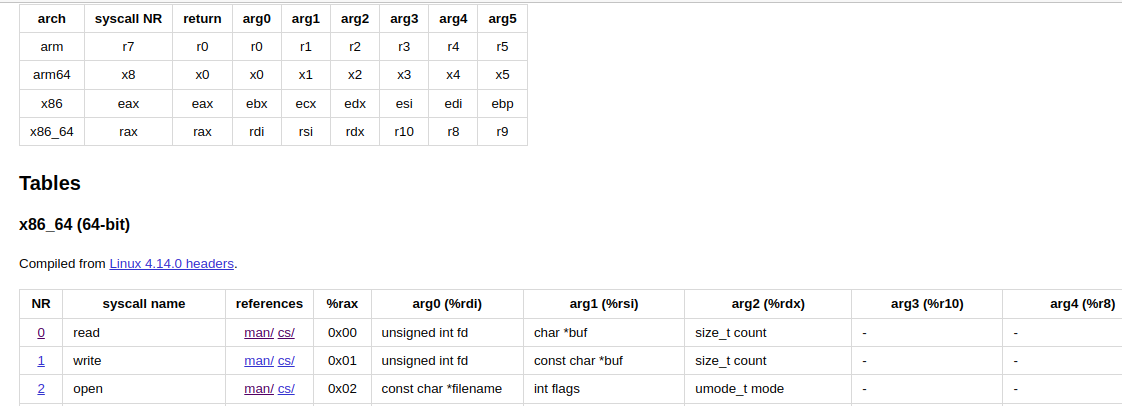

- Номер системного вызова **rax = 2**
- Адрес строки, содержащей имя файла: **rdi**
- Параметр флагов: **rsi**
- Режим доступа: **rdx**
- Возвращаемый дескриптор файла: **rax**, если возникнет ошибка, то в **rax** вернется -1.

Тогда аналог только что продемонстрированной C-программы на языке ассемблера будет выглядеть так:

In [ ]:
format elf64
public _start

include 'func.asm'

section '.data' writable

pathname db "my", 0
place rb 5

_start:
   mov rax, 2
   mov rdi, pathname
   mov rsi, 1101o
   mov rdx, 777o
   syscall
   mov rsi, place
   call number_str
   call print_str
   call new_line
   call exit

Даже если мы ничего не сделали с созданным файлом, корректная работа с файлом предполагает, что его нужно освободить - закрыть. Иначе остальные ресурсы в течение времени работы нашей программы не смогут с ним работать.

Закрытие файла происходит по команде **close**, это системный вызов с номером 3 (загружается в **rax**). Он требует одного входного параметра - дескриптора закрываемого файла (загружается в **rdi**).

Тогда наша программа может быть модифицирована следующим образом:

In [ ]:
format elf64
public _start

include 'func.asm'

section '.data' writable

pathname db "my", 0
place rb 5

_start:
   ;;Системный вызов open
   mov rax, 2
   mov rdi, pathname
   mov rsi, 1101o
   mov rdx, 777o
   syscall
   
   ;Сохраняем файловый дескриптор
   push rax
   
   ;;Печатаем значение файлового дескриптора
   mov rsi, place
   call number_str
   call print_str
   call new_line
   
   pop rax
   cmp rax, 0
   jl .l1
   
   ;;Системный вызов close
   mov rdi, rax
   mov rax, 3
   syscall
   
.l1:
   call exit

Попробуем теперь прочитать информацию из файла и вывести ее на печать. У нас получится своеобразный **cat**. Для этого имя файла будем передавать в параметрах командной строки.

Чтение из файла осуществляется уже рассмотренным нами системным вызовом **read**, только теперь вместо стандартного дескриптора ввода **stdin** мы должны подать файловый дескриптор.

In [ ]:
format elf64
public _start

include 'func.asm'

section '.data' writable

buffer rb 101

section '.text' executable

_start:
   pop rcx ;читаем количество параметров командной строки
   cmp rcx, 1 ;если один параметр(имя исполняемого файла)
   je .l1 ;завершаем работу

   mov rdi,[rsp+8] ;загружаем адрес имени файла из стека
   mov rax, 2 ;системный вызов открытия файла
   mov rsi, 0o ;Права только на чтение
   syscall
   cmp rax, 0 ;если вернулось отрицательное значение,
   jl .l1 ;то произошла ошибка открытия файла, также завершаем работу
   
   mov r8, rax ;сохраняем файловый дескриптор
   
.loop_read: ;начинаем цикл чтения из файла
   mov rax, 0 ;номер системного вызова чтения
   mov rdi, r8 ;загружаем файловый дескриптор
   mov rsi, buffer ;указываем, куда помещать прочитанные данные
   mov rdx, 100 ;устанавливаем количество считываемых данных
   syscall ;выполняем системный вызов read
   cmp rax, 0 ;если прочитано 0 байт, то достигли конца файла 
   je .next  ;выходим из цикла чтения
   mov byte [rsi+rax], 0 ;добавляем в буффер конец строки
   call print_str ;печатаем содержимое буффера
   jmp .loop_read ;продолжаем цикл чтения
 
.next:   ;;Системный вызов close
   mov rdi, r8
   mov rax, 3
   syscall
   
.l1:
   call exit

Попробуем теперь слегка модифицировать наш код, чтобы определить объем файла, заданного первым параметром командной строки.

Очевидно, что в этом случае вместо вывода на экран прочитанных символов нужно просто считать их количество.

In [ ]:
format elf64
public _start

include 'func.asm'

section '.data' writable

buffer rb 101

section '.text' executable

_start:
   pop rcx ;читаем количество параметров командной строки
   cmp rcx, 1 ;если один параметр(имя исполняемого файла)
   je .l1 ;завершаем работу

   mov rdi,[rsp+8] ;загружаем адрес имени файла из стека
   mov rax, 2 ;системный вызов открытия файла
   mov rsi, 0o ;Права только на чтение
   syscall
   cmp rax, 0 ;если вернулось отрицательное значение,
   jl .l1 ;то произошла ошибка открытия файла, также завершаем работу
   
   mov r8, rax ;сохраняем файловый дескриптор
   xor r9, r9  ;счетчик количества прочитанных байт
.loop_read: ;начинаем цикл чтения из файла
   mov rax, 0 ;номер системного вызова чтения
   mov rdi, r8 ;загружаем файловый дескриптор
   mov rsi, buffer ;указываем, куда помещать прочитанные данные
   mov rdx, 100 ;устанавливаем количество считываемых данных
   syscall ;выполняем системный вызов read
   cmp rax, 0 ;если прочитано 0 байт, то достигли конца файла 
   je .next  ;выходим из цикла чтения
   add rax, r9 ;копим прочитанные байты
   xchg rax, r9 ;сохраняем результат в r9
   jmp .loop_read ;продолжаем цикл чтения
.next: 
   xchg rax, r9 ;возвращаем результат в rax
   mov rsi, buffer ;переписываем число из rax
   call number_str ;в виде строки в буфер
   call print_str ;печатаем из буфера
   call new_line
  ;;Системный вызов close
   mov rdi, r8
   mov rax, 3
   syscall
   
.l1:
   call exit

Ниже представлен скриншот, подтверждающий работоспособность:

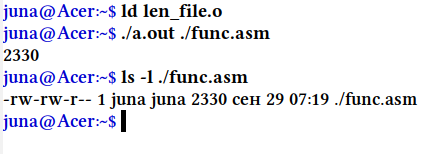

Попробуем теперь задавать в командной строке код символа, подсчет количества которого необходимо осуществить в файле. Например, если ввести код 10 (разрыв строки), то фактически будет произведен подсчет количества строк в файле.

In [ ]:
format elf64
public _start

include 'func.asm'

section '.data' writable

buffer rb 1

section '.text' executable

_start:
   pop rcx ;читаем количество параметров командной строки
   cmp rcx, 3 ;если один параметр(имя исполняемого файла)
   jne .l1 ;завершаем работу

   mov rdi,[rsp+8] ;загружаем адрес имени файла из стека
   mov r10, [rsp+16] ;загружаем адрес символа, который подсчитывается
   xor r12, r12 ;обнуляем регистр r12
   mov r12L,  [r10] ;загружаем в младшую часть регистра символ, который будем искать
   mov rax, 2 ;системный вызов открытия файла
   mov rsi, 0o ;Права только на чтение
   syscall ;выполняем системный вызов open
   cmp rax, 0 ;если вернулось отрицательное значение,
   jl .l1 ;то произошла ошибка открытия файла, также завершаем работу
   
   mov r8, rax ;сохраняем файловый дескриптор
   xor r9, r9 ;обнуляем счетчик
 .loop_read: ;начинаем цикл чтения из файла
   mov rax, 0 ;номер системного вызова чтения
   mov rdi, r8 ;загружаем файловый дескриптор
   mov rsi, buffer ;указываем, куда помещать прочитанные данные
   mov rdx, 1 ;устанавливаем количество считываемых данных
   syscall ;выполняем системный вызов read
   cmp rax, 0 ;если прочитано 0 байт, то достигли конца файла 
   je .next  ;выходим из цикла чтения
   cmp [buffer], r12L ;проверяем совпадение
   jne .loop_read
   inc r9 ;если совпали, считаем
   jmp .loop_read ;продолжаем цикл чтения
.next: 
   xchg rax, r9 ;возвращаем результат в rax
   mov rsi, buffer ;переписываем число из rax
   call number_str ;в виде строки в буфер
   call print_str ;печатаем из буфера
   call new_line
  ;;Системный вызов close
   mov rdi, r8
   mov rax, 3
   syscall
   
.l1:
   call exit

Ниже представлены примеры использования:

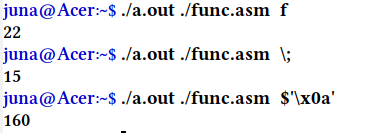

Из приведенного скриншота видно, что в файле 'func.asm' найдено 22 символа 'f'.  Для подсчета специальных символов следует использовать экранирование в виде:
> \ ; 

что означает - подсчет количества символов ";"

Если символ нельзя ввести с клавиатуры (например, знак перевода строки), то его можно ввести через его ASCII-код, используя нотацию: 

> $'\hex-code'

Так для Enter это имеет вид:
> $'\x0a'

Таким образом, в файле func.asm' содержится 160 строк.

## 3. Получение информации о файле, права доступа к файлам.

Как было отмечено в начале, каждому файлу присваивается уникальная в данной файловой системе численная величина, которая называется **номером индексного дескриптора**.

Метаинформация о файле, включая номер индексного дескриптора,  права доступа, время последнего доступа, владельца, группу, размер и т.д., хранится в **индексном дескрипторе**.

Получить номер индексного дескриптора можно с помощью команды ls и флага -i:

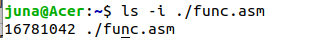

В этой конкретной файловой системе ни один другой файл не может иметь такого же номера. О другой файловой системе, однако, мы не можем утверждать этого.

Для получения информации из индексного дескриптора в Linux существуют специальные команды и соответствующие системные вызовы.

Linux предоставляет семейство функций для получения метаданных файла:

In [ ]:
#include <sys/types.h>
#include <sys/stat.h>
#include <unistd.h>
int stat (const char *path, struct stat *buf);
int fstat (int fd, struct stat *buf);
int lstat (const char *path, struct stat *buf);

Каждая из этих функций возвращает информацию о файле. Функция stat() предоставляет информацию о файле, определенном через path, в то время как fstat() возвращает информацию о файле, представленном файловым дескриптором fd.

Функция lstat() идентична stat(), за исключением того, что в случае передачи ей символической ссылки lstat() возвращает информацию о самой ссылке, а не о конечном файле.

Каждая из этих функций хранит информацию в структуре stat, которая предоставляется пользователям. Структура stat определена в заголовочном файле /usr/include/asm-generic/stat.h.

In [ ]:
struct stat {
 dev_t st_dev; /* идентификатор устройства, на котором хранится файл */
 ino_t st_ino; /* номер индексного дескриптора */
 mode_t st_mode; /* разрешения */
 nlink_t st_nlink; /* количество жестких ссылок */
 uid_t st_uid; /* пользовательский идентификатор владельца */
 gid_t st_gid; /* групповой идентификатор владельца */
 dev_t st_rdev; /* идентификатор устройства (для специальных файлов */
 off_t st_size; /* общий размер в байтах */
 blksize_t st_blksize; /* размер блока для ввода-вывода в файловой системе */
 blkcnt_t st_blocks; /* количество выделенных блоков */
 time_t st_atime; /* время последнего доступа */
 time_t st_mtime; /* время последней модификации */
 time_t st_ctime; /* время последнего изменения метаданных */
};

Чтобы корректно читать данные из этой структуры на ассемблере нужно понимать сколько байт в языке С отводится под каждый указанный в структуре тип данныx (причем это зависит от архитектуры и ядра операционной системы), а также в каком порядке следуют поля этой структуры в памяти. 

Нужно отметить, что структура stat претерпевала изменения и в разных ядрах она разная - в основном в более новых ядрах Linux под типы данных берется больше разрядов. В самом системном вызове stat из таблицы системных вызовов указано, что используется старая структура:

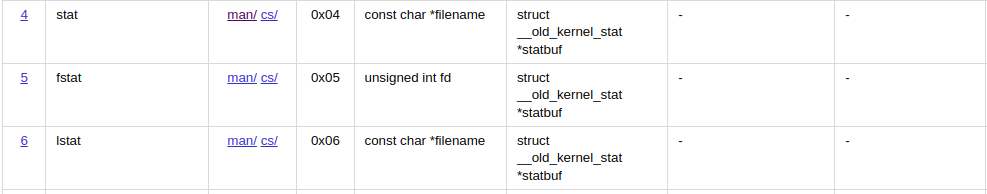

Но на практике все еще усугубляется тем, что порядок следования полей структуры в памяти отличается от перечисления их в справочных руководствах, какие-то фрагменты памяти вообще просто резервируются. Это не создает никаких проблем при обращении к полям этой структуры по именам в языке C, но на ассемблере нужно знать точный порядок следования их в памяти.

Выходом из этой ситуации может стать просмотр дампа памяти после выполнения системного вызова в ассемблере и сопоставление аналогичных значений в программе на С для одного и того же файла:
Вот программка на С, которая показывает такую информацию:

In [ ]:
#include <sys/types.h>
#include <sys/stat.h>
#include <unistd.h>
#include <stdio.h>
int main (int argc, char *argv[])
{
   struct stat sb;
   int ret;
   if (argc < 2) {
     printf("Error count args\n");
     return 1;
   }
   ret = stat (argv[1], &sb);
   if (ret) {
     perror ("stat");
     return 1;
   }
    printf ("st_dev: %ld, size st_dev: %lu\n", sb.st_dev, sizeof(dev_t));
    printf ("st_ino: %ld, size st_ino: %lu\n", sb.st_ino, sizeof(ino_t));
    printf ("st_mode: %ld, size st_mode: %lu\n", sb.st_mode, sizeof(mode_t));
    printf ("st_nlink: %ld, size st_nlink: %lu\n", sb.st_nlink, sizeof(nlink_t));
    printf ("st_uid: %ld, size st_uid: %lu\n", sb.st_uid, sizeof(uid_t));
    printf ("st_gid: %ld, size st_gid: %lu\n", sb.st_gid, sizeof(gid_t));
    printf ("st_rdev: %ld, size st_rdev: %lu\n", sb.st_rdev, sizeof(dev_t));
    printf ("st_size: %ld, size st_size: %lu\n", sb.st_size, sizeof(off_t));
    printf ("st_blksize: %ld, size st_blksize: %lu\n", sb.st_blksize, sizeof(blksize_t));
    printf ("st_blocks: %ld, size st_blocks: %lu\n", sb.st_blocks, sizeof(blkcnt_t));
    printf ("st_atime: %ld, size  st_atime: %lu\n", sb.st_atime, sizeof(time_t));
    printf ("st_mtime: %ld, size  st_mtime: %lu\n", sb.st_mtime, sizeof(time_t));
    printf ("st_ctime: %ld, size  st_ctime: %lu\n", sb.st_ctime, sizeof(time_t));

    return 0;
}

На рисунке ниже такое сопоставление приведено:

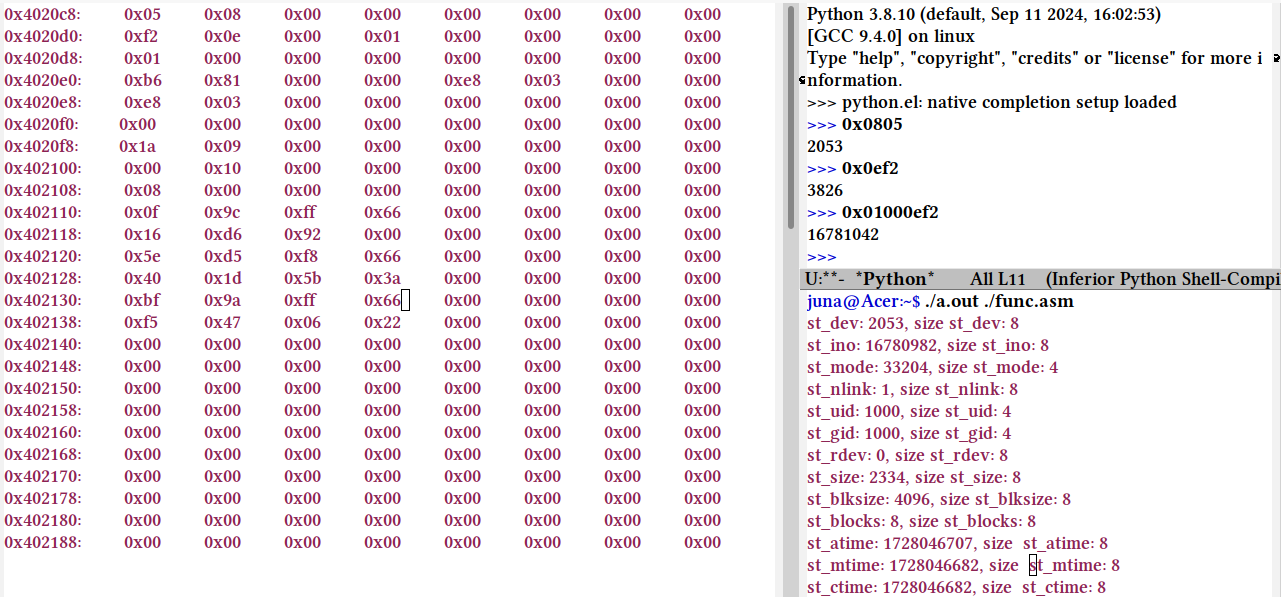

В правом нижнем буфере показан вывод программы на языке C для файла func.asm, слева показан дамп памяти в ассемблере при выполнении системного вызова stat на этом же файле. В верхнем левом углу производятся переводы чисел из дампа памяти (младшие разряды записываются по младшим адресам).

В результате такого сопоставления в fasm была построена следующая структура:

In [ ]:
Struc stat
{
  .st_dev dq ?        
  .st_ino dq ?
  .st_nlink dq ? ;Обратите внимание, порядок полей st_nlink, st_mode не совпадает со справочной информацией 
  .st_mode dd ?
  .st_uid dd ?        
  .st_gid dd ?        
  .st_rdev dq ?  
  .st_res_1 dd ? ; Здесь имеется резервное поле в 4 байта      
  .st_size dq ?        
  .st_blksize dq ?     
  .st_blocks dq ?      
  .st_atime dq ?  
  .st_atime_nsec dq ? ;В последних версиях ядра соответствуюшие значения имеются еще в наносекундах  
  .st_mtime dq ? 
  .st_mtime_nsec dq ? ;В последних версиях ядра соответствуюшие значения имеются еще в наносекундах  
  .st_ctime dq ?       
  .st_ctime_nsec dq ? ;В последних версиях ядра соответствуюшие значения имеются еще в наносекундах  
}

Попробуем на ассемблере написать программу, которая для файла, переданного в командной строке получает некоторую метаинформацию.

Данная программа может выглядеть так:

In [ ]:
format elf64
public _start



include 'func.asm'

section '.bss' writable

Struc stat
{
  .st_dev dq ?        
  .st_ino dq ?
  .st_nlink dq ? 
  .st_mode dd ?
  .st_uid dd ?        
  .st_gid dd ?        
  .st_rdev dq ?  
  .st_res_1 dd ?       
  .st_size dq ?        
  .st_blksize dq ?     
  .st_blocks dq ?      
  .st_atime dq ?  
  .st_atime_nsec dq ?   
  .st_mtime dq ? 
  .st_mtime_nsec dq ?    
  .st_ctime dq ?       
  .st_ctime_nsec dq ? 
}

buffer rb 200
mystat stat 

section '.text' executable

_start:
   pop rcx ;читаем количество параметров командной строки
   cmp rcx, 1 ;если один параметр(имя исполняемого файла)
   je .l1 ;завершаем работу

   mov rdi,[rsp+8] ;загружаем адрес имени файла из стека
   mov rax, 2 ;системный вызов открытия файла
   mov rsi, 0o ;Права только на чтение
   syscall ;системный вызов открытия файла
   cmp rax, 0 ;если вернулось отрицательное значение,
   jl .l1 ;то произошла ошибка открытия файла, также завершаем работу

   mov r8, rax ;сохраняем файловый дескриптор
   mov rax, 4
   mov rsi, mystat
   syscall

   ;;Системный вызов close
   mov rdi, r8
   mov rax, 3
   syscall

   xor rax, rax
   mov rax, [mystat.st_dev]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line

   xor rax, rax
   mov rax, [mystat.st_ino]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line

   xor rax, rax
   mov rax, [mystat.st_nlink]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line

   xor rax, rax
   mov eax, dword [mystat.st_mode]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line

   xor rax, rax
   mov eax, dword [mystat.st_uid]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line

   xor rax, rax
   mov eax, dword [mystat.st_gid]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line

   xor rax, rax
   mov rax, [mystat.st_rdev]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line

   xor rax, rax
   mov rax, [mystat.st_size]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line

   xor rax, rax
   mov rax, [mystat.st_blksize]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line
   
   xor rax, rax
   mov rax, [mystat.st_blocks]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line
   
   xor rax, rax
   mov rax, [mystat.st_atime]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line
   
   xor rax, rax
   mov rax, [mystat.st_mtime]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line

   xor rax, rax
   mov rax, [mystat.st_ctime]
   mov rsi, buffer
   call number_str
   mov rsi, buffer
   call print_str
   call new_line

.l1:
   call exit

Ниже представлен результат работы данной программы в сопоставлении с программой на C:

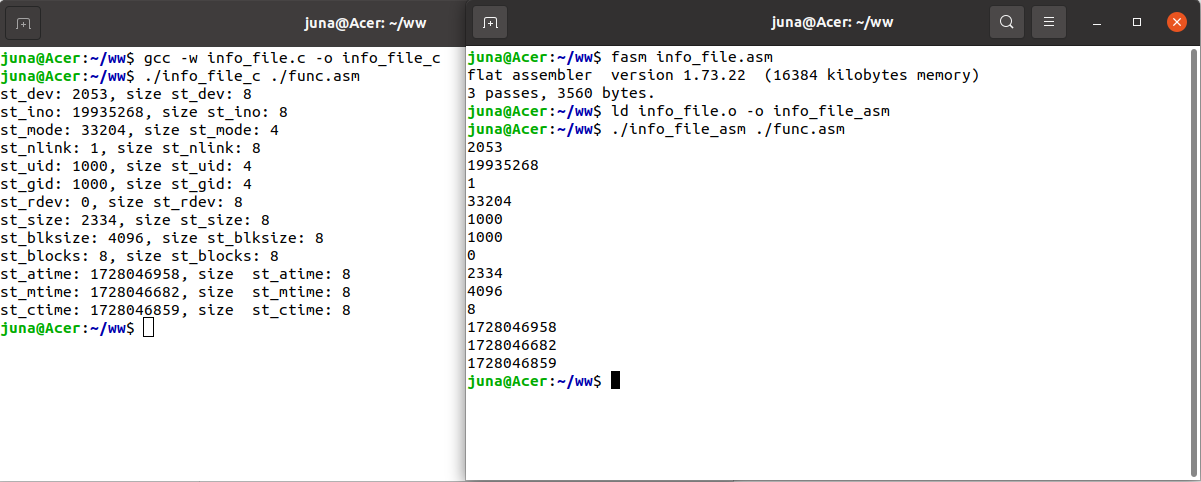

С помощью вызовов stat можно получить значения разрешений для данного файла, но для их изменения используются два других системных вызова:

In [ ]:
#include <sys/types.h>
#include <sys/stat.h>
int chmod (const char *path, mode_t mode);
int fchmod (int fd, mode_t mode);

Оба вызова **chmod() и fchmod()** устанавливают mode в качестве значения системных разрешений. В вызове **chmod()** относительный или абсолютный путь к файлу указывается в переменной path. В fchmod() файл определяется файловым дескриптором fd.

Допустимые величины **mode**, представленные целочисленным типом **mode_t**, те же, что возвращаются соответствующем полем в структуре stat. 

Фактически **mode** содержит 12 бит, которые и определяют права доступа. 

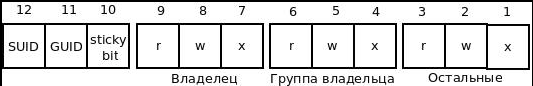

Биты 9, 8, 7 определяют права на чтение, запись, выполнение соответственно владельца файла. Если бит равен 1, то данное действие разрешено. 


Биты 6, 5, 4 – дают аналогичные права, но для группы собственника. Наконец, биты 3, 2, 1 – дают разрешения для всех остальных. 

Битовые тройки удобно записывать с помощью восьмеричной системы. Например, $400o$ означает право читать для собственника, а $700o$ – все права для собственника. 

|OCT |BIN| Mask|Права на файл|Права на каталог|
|--|--|--|--|--|
|0|000|- - -|отсутствие прав|отсутствие прав|
|1|001|- - x|права на выполнение|доступ к файлам и их атрибутам, нет возможности получить список имен файлов и создать/удалить/переименовать файл в каталоге|
|2|010|- w -|права на запись|отсутствие прав|
|3|011|- w x|права на запись и выполнение|все, кроме доступа к именам файлов. Можно читать/изменять/запускать(если разрешено правами на сам файл), а также создавать/удалять/переименовывать файл, но только если вы знаете его имя. Узнать имена файлов в каталоге - нет никакой возможности|
|4|100|r - -|права на чтение|только чтение имен файлов|
|5|101|r - x|права на чтение и выполнение|чтение имен файлов и доступ файлам и их атрибутам. Нет возможности создавать/удалять/переименовывать файлы в каталоге.|
|6|110|r w -|права на чтение и запись|только чтение имен файлов|
|7|111|r w x|полные права|все права|

Последние три бита специальные. 10-й бит, это так называемый «sticky bit». Если он равен 1, то файл может удалить только его владелец (и root тоже), независимо от других прав пользователей. 

12-й бит - SUID (set user id upon execution). Если он установлен, то файл можно запускать (если это программа) с правами собственника. 

11-й бит – SGID (set group id upon execution), если этот бит установлен, то файл можно запускать от имени группы собственника.


В таблице системных вызовов **chmod() и fchmod()** имеют номера 90 и 91 соответственно.

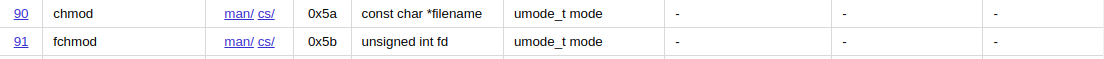

При задании прав с помощью 64-разрядных регистров значимыми являются только первые 12 бит.

Рассмотрим пример на использование системного вызова **chmod**. Пусть программа принимает два параметры: имя файла, права доступа и устанавливает такие права на данный файл.

In [ ]:
format elf64
public _start

include 'func.asm'

section '.text' executable
_start:
  pop rcx 
  cmp rcx, 3 
  jl .l1 

  mov rdi,[rsp+8] 
  mov rsi, [rsp+16] 
  call str_number
  mov rsi, rax
  mov rax, 90 
  syscall 
  
;В случае неуспеха в rax возвращается -1, иначе 0
  mov rdi, rax
  mov rax, 0x3c
  syscall

.l1:
  mov rax, 0x3c
  mov rdi, -1
  syscall

На скриншоте прриведены примеры работы с данной программой. Обратите внимание, что права доступа вводятся как числа в десятичной системе счисления и их нужно соответствующим образом интерпретировать в восьмиричной системе счисления (для этого используется python):

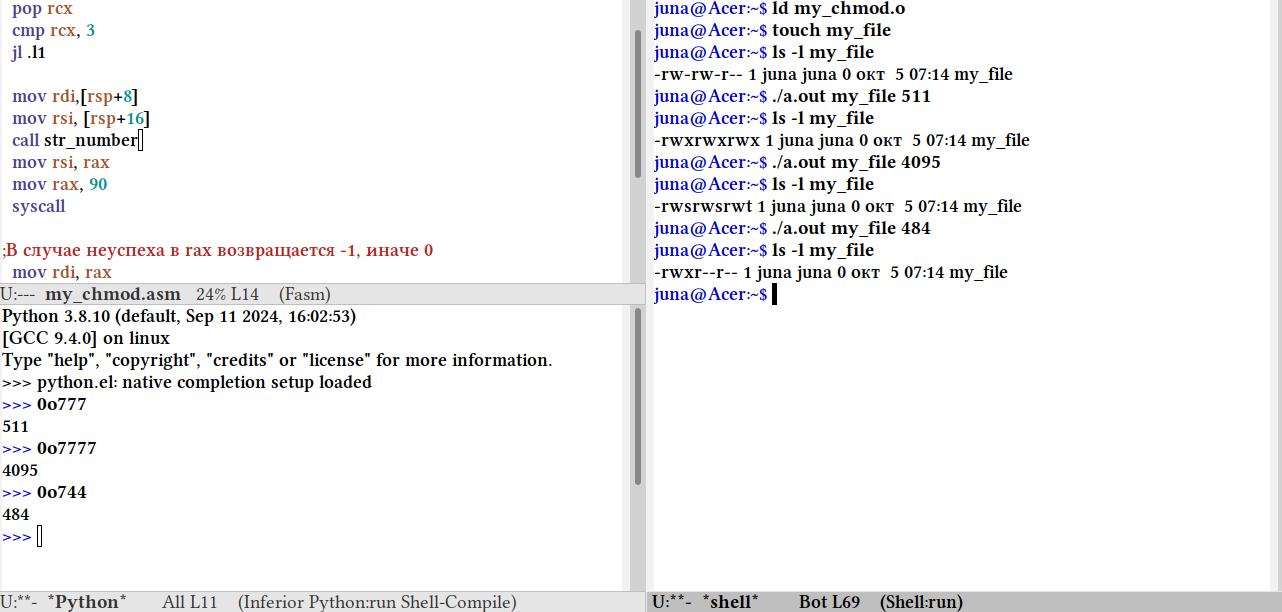

## 4. Позиционирование в файле, запись в файл, копирование.

Рассмотрим теперь еще один системный вызов, с помощью которого можно перемещаться внутри файла на определенное количество байт.

В принципе это можно сделать последовательным чтением, но есть специальная команда: **lseek**.

Системный вызов **lseek()** предназначен для установки в заданное значение файловой позиции конкретного файлового дескриптора. Этот вызов не осуществляет никаких других операций, кроме обновления файловой позиции.

В синтаксисе С эта функция имеет следующий формат:

In [ ]:
#include <sys/types.h>
#include <unistd.h>
off_t lseek (int fd, off_t pos, int origin);

Поведение вызова **lseek()** зависит от аргумента **origin**, который может иметь одно из следующих значений.
- SEEK_CUR — текущая файловая позиция дескриптора fd установлена в его текущее значение плюс pos. Последний может иметь отрицательное, положительное или нулевое значение. Если pos равен нулю, то возвращается текущее значение файловой позиции.
- SEEK_END — текущая файловая позиция дескриптора fd установлена в текущее значение длины файла плюс pos, который может иметь отрицательное, положительное или нулевое значение. Если pos равен нулю, то смещение устанавливается в конец файла.
- SEEK_SET — текущая файловая позиция дескриптора fd установлена в pos. Если pos равен нулю, то смещение устанавливается в начало файла.

В случае успеха этот вызов возвращает новую файловую позицию. При ошибке он возвращает –1 и присваивает errno соответствующее значение.

В таблице системных вызовов **lseek** имеет номер 8, файловый дескриптор fd должен быть загружен в регистр **rdi**, смещение **pos** в регистр **rsi**, **origin** загружается в **rdx** и приминает значения для **SEEK_SET**: 0, для **SEEK_CUR**: 1, для **SEEK_END**: 2.

После выхода в **rax** хранится текущая позиция.

Функция может выходить за конец файла, при этом не возникает ошибки и длина файла не меняется. Но если произведете запись за концом файла, то длина его увеличится на длина равную длине записи плюс количество байтов от конца файла до начала записи. При этом последний промежуток заполняется символами с кодом 0. 

Еще одна полезная идея использования **lseek** - если взять третий параметр равным 2, а смещение равным 0, то функция как раз возвратит позицию равную длине файла. 

Разработаем программу, которая находит длину файла с использованием **lseek**.

In [ ]:
format elf64
public _start

include 'func.asm'

section '.bss' writable
  
  buffer rb 100

_start:
  pop rcx 
  cmp rcx, 1 
  je .l1 

  mov rdi,[rsp+8] 
  mov rax, 2 
  mov rsi, 0o 
  syscall 
  cmp rax, 0 
  jl .l1 
  
  mov r8, rax
  
  mov rax, 8
  mov rdi, r8
  mov rsi, 0
  mov rdx, 2
  syscall
  
  mov rsi, buffer
  call number_str
  call print_str
  call new_line
  
  mov rdi, r8
  mov rax, 3
  syscall

.l1:
  call exit

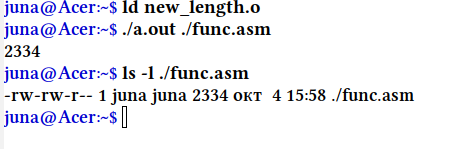

Теперь попробуем разработать программу, которая выводит содержимое файла в обратном порядке, имя файла также передается в командной строке. 

In [ ]:
format elf64
public _start

include 'func.asm'

section '.bss' writable
  
  buffer rb 2

_start:
  pop rcx 
  cmp rcx, 1 
  je .l1 

  mov rdi,[rsp+8] 
  mov rax, 2 
  mov rsi, 0o 
  syscall 
  cmp rax, 0 
  jl .l1 
  
  mov r8, rax
  
  mov rax, 8
  mov rdi, r8
  mov rsi, 0
  mov rdx, 2
  syscall

  mov r10, rax ;сохраняем длину файла

.loop:
   cmp r10, 0
   jl .l2
   mov rax, 0
   mov rdi, r8
   mov rsi, buffer
   mov rdx, 1 
   syscall 
   mov [buffer+1], 0
   call print_str
   dec r10
   mov rax, 8
   mov rdi, r8
   mov rsi, r10
   mov rdx, 0
   syscall
   jmp .loop
   
.l2:
  call new_line
  mov rdi, r8
  mov rax, 3
  syscall

.l1:
  call exit

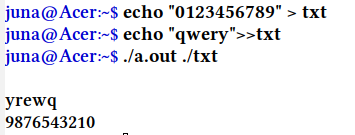

С помощью **lseek()** можно переставить указатель файловой позиции за пределы файла (дальше его конечной точки). 

Само по себе позиционирование с выходом за пределы файла не дает результата — запрос на считывание такой новой файловой позиции вернет значение EOF (конец файла). Однако если затем сделать запрос на запись, указав такую конечную позицию, то между старым и новым значениями длины файла будет создано дополнительное пространство, которое программа заполнит нулями.

**Такое заполнение нулями называется дырой**. В UNIX-подобных файловых системах дыры не занимают на диске никакого пространства. Таким образом, общий размер всех файлов, содержащихся в файловой системе, может превышать физический размер диска. **Файлы, содержащие дыры, называются разреженными**. 

При использовании разреженных файлов можно экономить значительное пространство на диске, а также оптимизировать производительность, ведь при манипулировании дырами не происходит никакого физического ввода-вывода.

Запрос на считывание фрагмента файла, полностью находящегося в пределах дыры, вернет соответствующее количество нулей.

Рассмотрим теперь порядок записи в файл. 

Для этого используется все тот же системный вызов **write**.

В качестве примера разработаем программу, которая записывает в файл все четные от 1 до $n$. Число $n$ введем как параметр командной строки.

In [ ]:
format elf64
public _start

include 'func.asm'

section '.bss' writable
  
  buffer rb 100

section '.text' executable

_start:
  pop rcx 
  cmp rcx, 1 
  je .l1 

  mov rdi,[rsp+8] 
  mov rax, 2 
  ;;Формируем O_WRONLY|O_TRUNC|O_CREAT
  mov rsi, 577
  mov rdx, 777o
  syscall 
  cmp rax, 0 
  jl .l1 
  
  ;;Сохраняем файловый дескриптор
  mov r8, rax

  ;;Читаем n в r9
  mov rsi, [rsp+16]
  call str_number
  mov r9, rax
  
  ;;Начинаем цикл
  mov rbx, 1
 .loop:
   inc rbx
   cmp rbx, r9
   jg .l2
   mov rcx, 2
   mov rax, rbx
   xor rdx, rdx
   div rcx
   cmp rdx, 0
   jne .loop
   
   mov rax, rbx
   mov rsi, buffer
   call number_str

   mov rax, buffer
   call len_str
   mov rdx, rax
   mov [buffer+rdx],0x0a
   inc rdx
   
   mov rax, 1
   mov rdi, r8
   mov rsi, buffer
   syscall
   jmp .loop 

.l2:  
  mov rdi, r8
  mov rax, 3
  syscall

.l1:
  call exit

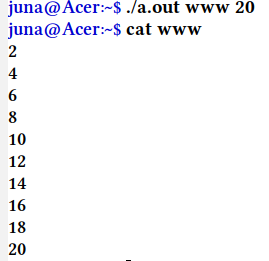

Рассмотрим теперь аналог программы **cp** копирования файлов. Фактически нужно открыть два файла: один на чтение, другой на запись, читать из одного и записывать в другой. 

В предложенной ниже программе реализуется именно этот процесс. Файл, который нужно копировать, задается первым параметров командной строки, файл, куда нужно копировать - вторым параметром.

In [ ]:
format elf64
public _start

include 'func.asm'

section '.bss' writable

  buffer rb 100

section '.text' executable

_start:
  ;Считываем количество пааметров командной строки
   pop rcx
   cmp rcx, 3
   jl .l1

   ;открываем файл, который будем читать
   mov rdi,[rsp+8]
   mov rax, 2
   mov rsi, 0o
   syscall
   cmp rax, 0
   jl .l1
   ;Сохраняем дескриптор
   mov r8, rax

   ;открываем файл, в который будем копировать
   mov rdi,[rsp+16]
   mov rax, 2
   mov rsi, 577
   mov rdx, 777o
   syscall
   cmp rax, 0
   jl .l1
   ;Сохраняем дескриптор
   mov r9, rax

    ;Признак окончания чтения
   xor r10, r10
   .loop:
     mov rax, 0 ;номер системного вызова чтения
     mov rdi, r8
     mov rsi, buffer
     mov rdx, 100
     syscall
     cmp rax, 0
     jne .next
     inc r10
     .next:
       mov rdi, r9
       mov rdx, rax
       mov rax, 1
       mov rsi, buffer
       syscall
       cmp r10,0
       je .loop

   mov rdi, r8
   mov rax, 3
   syscall

   mov rdi, r9
   mov rax, 3
   syscall

.l1:
   call exit